# Time Series Forecasting with RNNs

*Prepared by Sebastian C. Ibañez*

--- 

<a href="https://colab.research.google.com/github/aim-msds/msds2022-ml3/blob/main/notebooks/05_RNN/03_sentiment-analysis.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="float: left;"></a><br>

In this notebook, our goal is to create a time series forecaster using an RNNs.

Specifically, we'll be using the Jena Climate dataset. The dataset was recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset, 14 different quantities such as air temperature, atmospheric pressure, humidity, wind direction, etc. were recorded every 10 minutes. Here, we limit our observations from from 2009–2016. 

Our goal will be to build a forecaster that can predict the next 24 hours.

Here are the actual variables in the data:

- Date Time   
- p (mbar) atmospheric pressure  
- T (degC) temperature  
- Tpot (K) potential temperature  
- Tdew (degC) dew point temperature  
- rh (%) relative humidity  
- VPmax (mbar) saturation water vapor pressure  
- VPact (mbar) actual water vapor pressure  
- VPdef (mbar) water vapor pressure deficit  
- sh (g/kg) specific humidity  
- H2OC (mmol/mol) water vapor concentration  
- rho (g/$m^3$) air density  
- wv (m/s) wind velocity  
- max. wv (m/s) maximum wind velocity  
- wd (deg) wind direction  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,3)

import tensorflow as tf

## Loading the Data

In [2]:
df = pd.read_csv('data/jena_climate_2009_2016.csv', index_col=0)
df.index = pd.to_datetime(df.index, dayfirst=True) # Set dayfirst=True or you will get the wrong dates
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


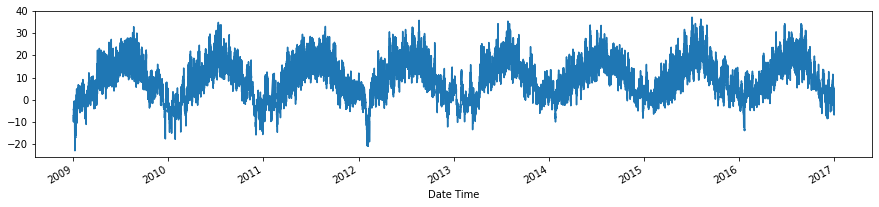

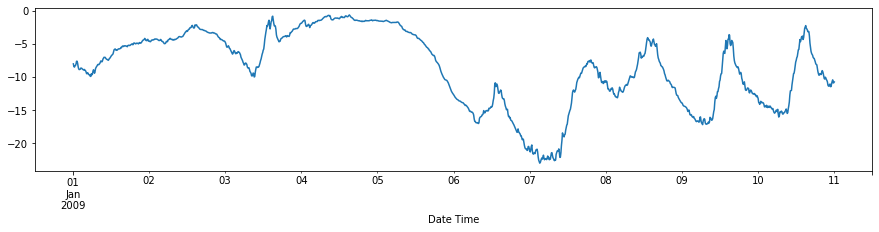

In [3]:
df['T (degC)'].plot()
plt.show()

df['T (degC)'][:1440].plot() # first 10 days, 24*6*10
plt.autoscale()
plt.show()

In [4]:
pd.isna(df).sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [5]:
print('Actual count:', len(df))
print('  Time count:', len(pd.date_range(start='2009-01-01 00:10:00', end='2017-01-01 00:00:00', freq='10min')))

Actual count: 420551
  Time count: 420768


## Resampling the Time Series

Aggregating (or disaggregating) a time series to change it's sampling frequency is somtimes referred to as **resampling** (not related to statistical resampling).

Check out [`pandas.Series.resample`](https://pandas.pydata.org/docs/reference/api/pandas.Series.resample.html) for more info.

In [6]:
df_hour = df.resample(rule='60min').mean().round(2)
df_hour

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:00:00,996.53,-8.30,265.12,-9.12,93.78,3.26,3.06,0.20,1.91,3.07,1309.20,0.52,1.00,174.46
2009-01-01 01:00:00,996.52,-8.06,265.36,-8.86,93.93,3.32,3.12,0.20,1.95,3.13,1307.98,0.32,0.71,172.42
2009-01-01 02:00:00,996.74,-8.76,264.64,-9.61,93.53,3.14,2.94,0.20,1.84,2.95,1311.82,0.25,0.61,196.82
2009-01-01 03:00:00,996.99,-8.90,264.49,-9.79,93.20,3.11,2.90,0.21,1.81,2.91,1312.81,0.18,0.61,157.08
2009-01-01 04:00:00,997.16,-9.35,264.03,-10.34,92.38,3.00,2.78,0.23,1.73,2.78,1315.36,0.29,0.67,150.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 20:00:00,1001.41,-2.50,270.55,-7.02,71.08,5.09,3.60,1.48,2.24,3.60,1287.17,0.92,1.53,203.53
2016-12-31 21:00:00,1001.06,-2.65,270.43,-6.97,72.02,5.02,3.62,1.41,2.25,3.61,1287.41,0.57,1.25,98.37
2016-12-31 22:00:00,1000.51,-3.55,269.57,-7.35,74.92,4.70,3.52,1.19,2.19,3.51,1291.06,0.82,1.41,167.96


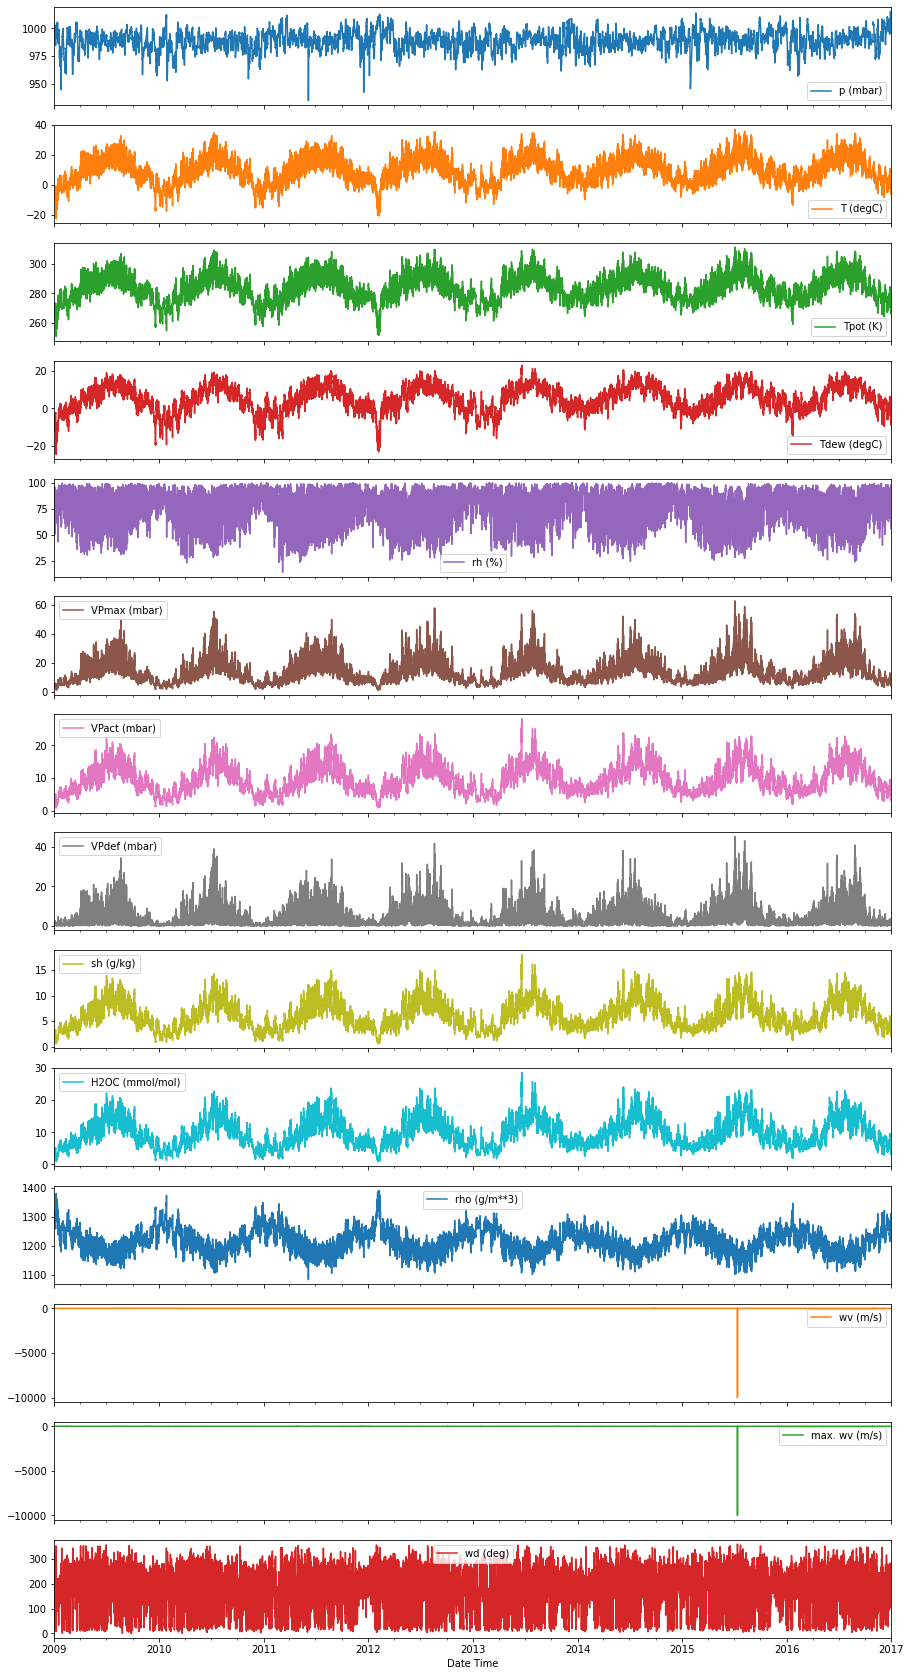

In [7]:
df_hour.plot(figsize=(15,30), subplots=True)
plt.show()

In [8]:
df_hour.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70041.0,989.214367,8.358626,934.91,984.21,989.57,994.73,1015.24
T (degC),70041.0,9.442387,8.414656,-22.65,3.36,9.41,15.46,37.04
Tpot (K),70041.0,283.484843,8.495635,250.97,277.43,283.46,289.52,310.98
Tdew (degC),70041.0,4.953448,6.727775,-24.60,0.23,5.22,10.07,23.02
rh (%),70041.0,76.028679,16.385651,13.68,65.31,79.27,89.35,100.00
VPmax (mbar),70041.0,13.568624,7.725256,0.98,7.78,11.82,17.60,62.94
VPact (mbar),70041.0,9.532316,4.180968,0.82,6.21,8.86,12.35,28.17
VPdef (mbar),70041.0,4.036222,4.874838,0.00,0.88,2.19,5.29,45.19
sh (g/kg),70041.0,6.021512,2.654108,0.52,3.92,5.60,7.80,18.03
H2OC (mmol/mol),70041.0,9.638785,4.232188,0.83,6.28,8.96,12.48,28.66


## Data Cleaning

In [9]:
df_hour['wv (m/s)'].loc[df_hour['wv (m/s)'] < 0] = 0
df_hour['max. wv (m/s)'].loc[df_hour['max. wv (m/s)'] < 0] = 0
df_hour.describe().T

,count,mean,std,min,25%,50%,75%,max
p (mbar),70041.0,989.214367,8.358626,934.91,984.21,989.57,994.73,1015.24
T (degC),70041.0,9.442387,8.414656,-22.65,3.36,9.41,15.46,37.04
Tpot (K),70041.0,283.484843,8.495635,250.97,277.43,283.46,289.52,310.98
Tdew (degC),70041.0,4.953448,6.727775,-24.60,0.23,5.22,10.07,23.02
rh (%),70041.0,76.028679,16.385651,13.68,65.31,79.27,89.35,100.00
VPmax (mbar),70041.0,13.568624,7.725256,0.98,7.78,11.82,17.60,62.94
VPact (mbar),70041.0,9.532316,4.180968,0.82,6.21,8.86,12.35,28.17
VPdef (mbar),70041.0,4.036222,4.874838,0.00,0.88,2.19,5.29,45.19
sh (g/kg),70041.0,6.021512,2.654108,0.52,3.92,5.60,7.80,18.03
H2OC (mmol/mol),70041.0,9.638785,4.232188,0.83,6.28,8.96,12.48,28.66


In [10]:
pd.isna(df_hour).sum()

p (mbar)           88
T (degC)           88
Tpot (K)           88
Tdew (degC)        88
rh (%)             88
VPmax (mbar)       88
VPact (mbar)       88
VPdef (mbar)       88
sh (g/kg)          88
H2OC (mmol/mol)    88
rho (g/m**3)       88
wv (m/s)           88
max. wv (m/s)      88
wd (deg)           88
dtype: int64

In [11]:
df_hour['T (degC)'].loc[pd.isna(df_hour['T (degC)'])]

Date Time
2014-09-24 18:00:00   NaN
2014-09-24 19:00:00   NaN
2014-09-24 20:00:00   NaN
2014-09-24 21:00:00   NaN
2014-09-24 22:00:00   NaN
                       ..
2016-10-28 07:00:00   NaN
2016-10-28 08:00:00   NaN
2016-10-28 09:00:00   NaN
2016-10-28 10:00:00   NaN
2016-10-28 11:00:00   NaN
Name: T (degC), Length: 88, dtype: float64

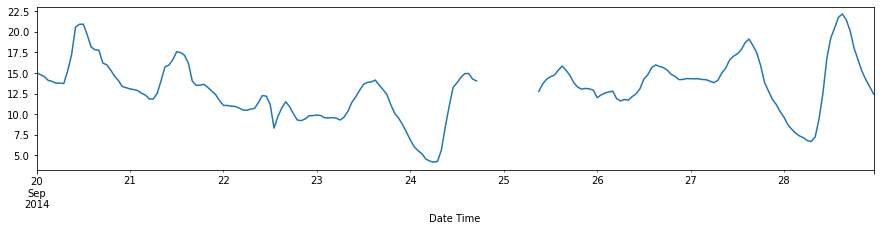

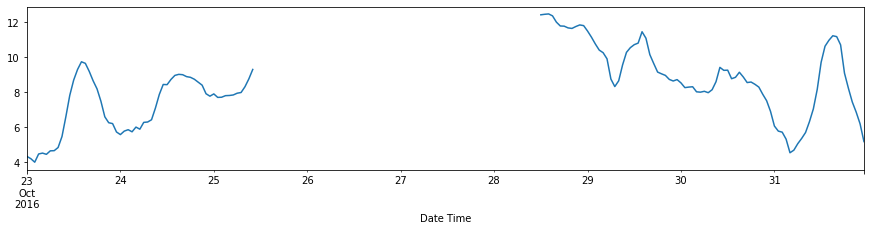

In [12]:
df_hour['T (degC)'].loc['2014-09-20':'2014-09-28'].plot()
plt.show()

df_hour['T (degC)'].loc['2016-10-23':'2016-10-31'].plot()
plt.show()

See [`pandas.DataFrame.interpolate`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html) for a list of interpolation methods.

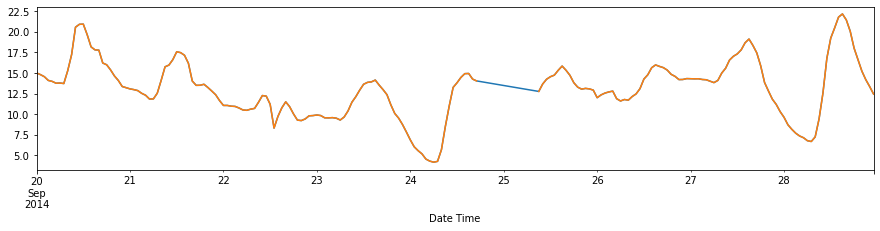

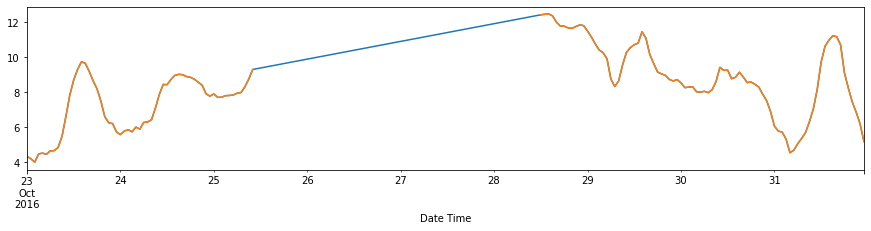

,count,mean,std,min,25%,50%,75%,max
p (mbar),88.0,0.010009,0.001532,0.0,0.00,0.01,0.01,0.0
T (degC),88.0,0.002338,-0.004905,0.0,0.01,0.01,0.00,0.0
Tpot (K),88.0,0.001521,-0.005063,0.0,0.01,0.00,-0.01,0.0
Tdew (degC),88.0,0.003930,-0.003303,0.0,0.01,0.01,-0.01,0.0
rh (%),88.0,0.006607,-0.007121,0.0,0.01,0.01,-0.02,0.0
VPmax (mbar),88.0,-0.000094,-0.004745,0.0,0.00,0.01,-0.01,0.0
VPact (mbar),88.0,0.001599,-0.002376,0.0,0.01,0.01,0.00,0.0
VPdef (mbar),88.0,-0.001692,-0.002630,0.0,0.00,0.01,-0.01,0.0
sh (g/kg),88.0,0.000938,-0.001531,0.0,0.00,0.00,0.00,0.0
H2OC (mmol/mol),88.0,0.001505,-0.002439,0.0,0.01,0.01,0.00,0.0


In [13]:
df_hour_inter = df_hour.interpolate(method='linear')

df_hour_inter['T (degC)'].loc['2014-09-20':'2014-09-28'].plot()
df_hour['T (degC)'].loc['2014-09-20':'2014-09-28'].plot()
plt.show()

df_hour_inter['T (degC)'].loc['2016-10-23':'2016-10-31'].plot()
df_hour['T (degC)'].loc['2016-10-23':'2016-10-31'].plot()
plt.show()

# Check stability of descriptive stats after interpolating
df_hour_inter.describe().T - df_hour.describe().T

In [14]:
# Apply inplace
df_hour.interpolate(method='linear', inplace=True)

## Train-Val-Test Split and Normalization

In [15]:
# 70-20-10 split
train_size = int(0.7 * len(df_hour))
val_size = int(0.2 * len(df_hour))
test_size = len(df_hour) - train_size - val_size

print(f'Train size: {train_size}')
print(f'  Val size: {val_size}')
print(f' Test size: {test_size}')

Train size: 49090
  Val size: 14025
 Test size: 7014


In [16]:
# Normalize per dataframe column
train_mean = df_hour[:train_size].mean()
train_std = df_hour[:train_size].std()

df_hour_norm = (df_hour - train_mean) / train_std

## Data Windowing (Example)

In [17]:
# Hyperparms (sequence lengths of inputs and outputs)
w = 3 # lookback window, AR lag parameter, conditioning range, input width, etc. (has lots of names)
h = 2 # prediction horizon, output width (not really hyperparam, its task specific)

# Other params
batch_size = 1
seed = 42

In [18]:
sample_sequence = np.arange(10)
print(sample_sequence.shape)
print(sample_sequence)

(10,)
[0 1 2 3 4 5 6 7 8 9]


In [19]:
sample_ds_x = tf.keras.utils.timeseries_dataset_from_array(
    data=sample_sequence[:-h], # drop last h obs
    targets=None,
    sequence_length=w, # lookback
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

sample_ds_y = tf.keras.utils.timeseries_dataset_from_array(
    data=sample_sequence[w:], # drop first w obs
    targets=None,
    sequence_length=h, # horizon
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

# zip both datasets
sample_ds = tf.data.Dataset.zip((sample_ds_x, sample_ds_y))

# print batches
for inputs, targets in sample_ds:
    print(inputs)
    print(targets)
    print('---')

tf.Tensor([[0 1 2]], shape=(1, 3), dtype=int32)
tf.Tensor([[3 4]], shape=(1, 2), dtype=int32)
---
tf.Tensor([[1 2 3]], shape=(1, 3), dtype=int32)
tf.Tensor([[4 5]], shape=(1, 2), dtype=int32)
---
tf.Tensor([[2 3 4]], shape=(1, 3), dtype=int32)
tf.Tensor([[5 6]], shape=(1, 2), dtype=int32)
---
tf.Tensor([[3 4 5]], shape=(1, 3), dtype=int32)
tf.Tensor([[6 7]], shape=(1, 2), dtype=int32)
---
tf.Tensor([[4 5 6]], shape=(1, 3), dtype=int32)
tf.Tensor([[7 8]], shape=(1, 2), dtype=int32)
---
tf.Tensor([[5 6 7]], shape=(1, 3), dtype=int32)
tf.Tensor([[8 9]], shape=(1, 2), dtype=int32)
---


In [20]:
# Multivariate example
sample_multi = np.stack([np.arange(10), np.arange(10)+100]).T
print(sample_multi.shape)
print(sample_multi)

(10, 2)
[[  0 100]
 [  1 101]
 [  2 102]
 [  3 103]
 [  4 104]
 [  5 105]
 [  6 106]
 [  7 107]
 [  8 108]
 [  9 109]]


In [21]:
sample_ds_x = tf.keras.utils.timeseries_dataset_from_array(
    data=sample_multi[:-h, ...], # drop last h obs
    targets=None,
    sequence_length=w, # lookback
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

sample_ds_y = tf.keras.utils.timeseries_dataset_from_array(
    data=sample_multi[w:, ...], # drop first w obs
    targets=None,
    sequence_length=h, # horizon
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

# zip both datasets
sample_ds = tf.data.Dataset.zip((sample_ds_x, sample_ds_y))

# print batches
for inputs, targets in sample_ds:
    print(inputs)
    print(targets)
    print('---')

tf.Tensor(
[[[  0 100]
  [  1 101]
  [  2 102]]], shape=(1, 3, 2), dtype=int32)
tf.Tensor(
[[[  3 103]
  [  4 104]]], shape=(1, 2, 2), dtype=int32)
---
tf.Tensor(
[[[  1 101]
  [  2 102]
  [  3 103]]], shape=(1, 3, 2), dtype=int32)
tf.Tensor(
[[[  4 104]
  [  5 105]]], shape=(1, 2, 2), dtype=int32)
---
tf.Tensor(
[[[  2 102]
  [  3 103]
  [  4 104]]], shape=(1, 3, 2), dtype=int32)
tf.Tensor(
[[[  5 105]
  [  6 106]]], shape=(1, 2, 2), dtype=int32)
---
tf.Tensor(
[[[  3 103]
  [  4 104]
  [  5 105]]], shape=(1, 3, 2), dtype=int32)
tf.Tensor(
[[[  6 106]
  [  7 107]]], shape=(1, 2, 2), dtype=int32)
---
tf.Tensor(
[[[  4 104]
  [  5 105]
  [  6 106]]], shape=(1, 3, 2), dtype=int32)
tf.Tensor(
[[[  7 107]
  [  8 108]]], shape=(1, 2, 2), dtype=int32)
---
tf.Tensor(
[[[  5 105]
  [  6 106]
  [  7 107]]], shape=(1, 3, 2), dtype=int32)
tf.Tensor(
[[[  8 108]
  [  9 109]]], shape=(1, 2, 2), dtype=int32)
---


## Data Windowing (Actual)

In [22]:
target = ['T (degC)']
covariates = ['p (mbar)']

ts = df_hour_norm[target + covariates].to_numpy() # we assume first column is the target
ts_train = ts[:train_size]
ts_val = ts[train_size:train_size+val_size]
ts_test = ts[train_size+val_size:]

In [23]:
# Hyperparms
w = 24*7 # one week lookback 
h = 24 # predict next 24 hours 

# Other params
batch_size = 64
seed = 42
shuffle = True

# Create train iterators
x_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_train = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_train[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create val iterators
x_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_val = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_val[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# Create test iterators
x_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[:-h, :], # use target + covariates
    targets=None,
    sequence_length=w,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

y_test = tf.keras.utils.timeseries_dataset_from_array(
    data=ts_test[w:, 0], # use target time series only!
    targets=None,
    sequence_length=h,
    batch_size=batch_size,
    shuffle=shuffle,
    seed=seed
)

# zip datasets
train_ds = tf.data.Dataset.zip((x_train, y_train))
val_ds = tf.data.Dataset.zip((x_val, y_val))
test_ds = tf.data.Dataset.zip((x_test, y_test))

# check sizes
for inputs, targets in train_ds:
    print(inputs.shape)
    print(targets.shape)
    break

(64, 168, 2)
(64, 24)


## Model Building

In [24]:
class seq2seq_gru(tf.keras.Model):
    def __init__(self, window, horizon, hidden_units):
        super(seq2seq_gru, self).__init__()
        self.window = window
        self.horizon = horizon
        self.hidden_units = hidden_units
        
        # GRU encoder
        self.encoder = tf.keras.layers.GRU(self.hidden_units,
                                           return_sequences=False,
                                           return_state=True)
        
        # GRU decoder
        self.decoder = tf.keras.layers.GRU(self.hidden_units,
                                           return_sequences=False,
                                           return_state=True)
        
        # Output layer
        self.dense = tf.keras.layers.Dense(1)

    def call(self, x, state=None):
        output = []
        
        # Encode inputs
        encoder_output, encoder_state = self.encoder(x, initial_state=state)

        # Get first decoder input, from final encoder output + dense
        encoder_output = tf.expand_dims(encoder_output, 1) # reshape to (batch, time, features)
        decoder_input = self.dense(encoder_output)
        
        # Generate first prediction
        decoder_output, decoder_state = self.decoder(decoder_input, initial_state=encoder_state)
        decoder_input = self.dense(decoder_output)
        
        # Place in final output
        output.append(decoder_input)
        
        # Generate predictions over the rest of the horizon
        for i in range(1, self.horizon):
            
            decoder_input = tf.expand_dims(decoder_input, 1) # reshape to (batch, time, features)

            decoder_output, decoder_state = self.decoder(decoder_input, initial_state=decoder_state)
            decoder_input = self.dense(decoder_output)
            
            output.append(decoder_input)

        # Stack and reshape
        output = tf.stack(output)                # (time, batch, features)
        output = tf.transpose(output, [1, 0, 2]) # (batch, time, features)
            
        return output

In [25]:
# Hyperparams
hidden_units = 32

model = seq2seq_gru(w, h, hidden_units)

# Loss, optimizer, and metric
model.compile(loss='huber', # huber is basically a combo of mse and mae
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # learning rate is something that should definitely be tuned!!!
              metrics=['mae'])

# Model checkpoint
checkpoint_filepath = 'training_checkpoints/'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True,
    verbose=False)

In [26]:
# train the model
epochs = 5

history = model.fit(
    x=train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback])

Epoch 1/5
765/765 [==============================] - 38s 29ms/step - loss: 0.1088 - mae: 0.3597 - val_loss: 0.0645 - val_mae: 0.2752
Epoch 2/5
765/765 [==============================] - 19s 24ms/step - loss: 0.0507 - mae: 0.2430 - val_loss: 0.0510 - val_mae: 0.2432
Epoch 3/5
765/765 [==============================] - 19s 25ms/step - loss: 0.0459 - mae: 0.2301 - val_loss: 0.0491 - val_mae: 0.2390
Epoch 4/5
765/765 [==============================] - 19s 25ms/step - loss: 0.0442 - mae: 0.2256 - val_loss: 0.0490 - val_mae: 0.2386
Epoch 5/5
765/765 [==============================] - 19s 25ms/step - loss: 0.0431 - mae: 0.2222 - val_loss: 0.0467 - val_mae: 0.2328


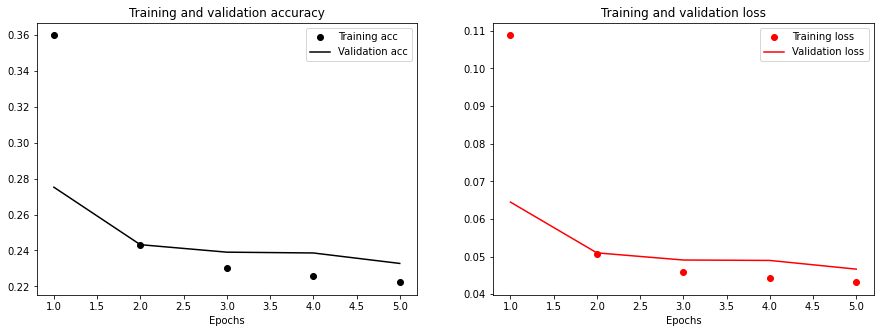

In [27]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()
    
    # plot accuracy 
    acc = history.history['mae']
    val_acc = history.history['val_mae']

    ax1.plot(epochs, acc, 'ko', label='Training acc')
    ax1.plot(epochs, val_acc, 'k', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

plot_results(history)

In [28]:
# load best weights
model.load_weights(checkpoint_filepath)

loss, mae = model.evaluate(test_ds)

print("MSE: ", loss)
print("MAE: ", mae)

107/107 [==============================] - 1s 12ms/step - loss: 0.0371 - mae: 0.2085
MSE:  0.03706081956624985
MAE:  0.20851118862628937


## Plotting Sample Forecasts

RMSE:  2.0925357
 MAE:  1.6736587


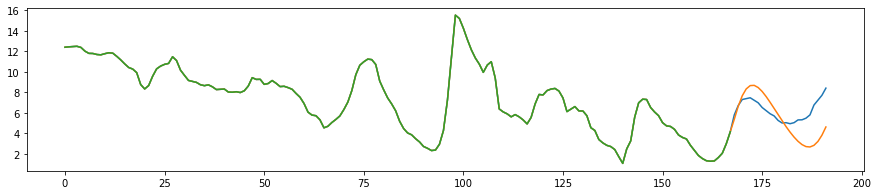

RMSE:  0.9994121
 MAE:  0.8396737


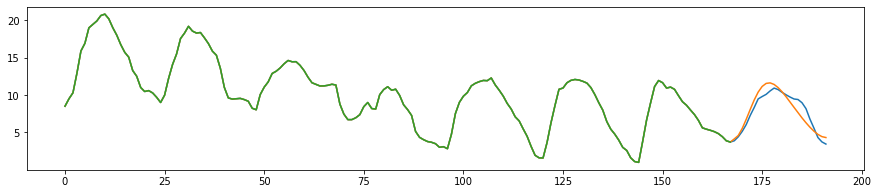

RMSE:  3.042712
 MAE:  2.7088044


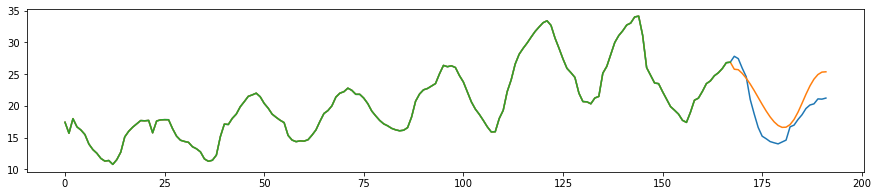

RMSE:  2.2848883
 MAE:  2.056162


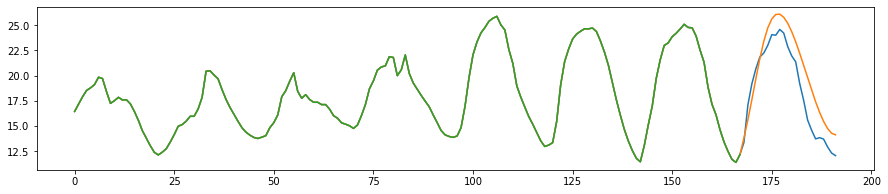

RMSE:  0.57064235
 MAE:  0.51561445


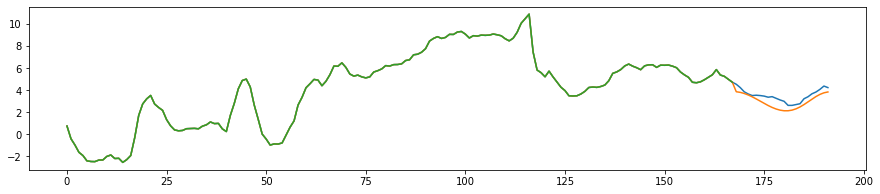

RMSE:  0.89304984
 MAE:  0.68489236


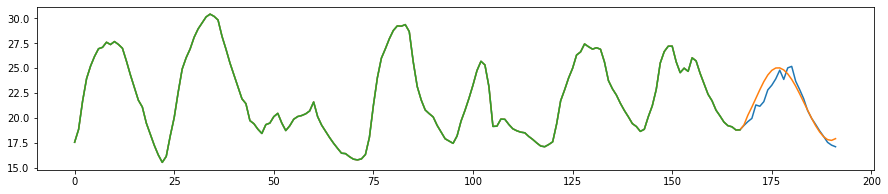

RMSE:  1.3716323
 MAE:  1.0098288


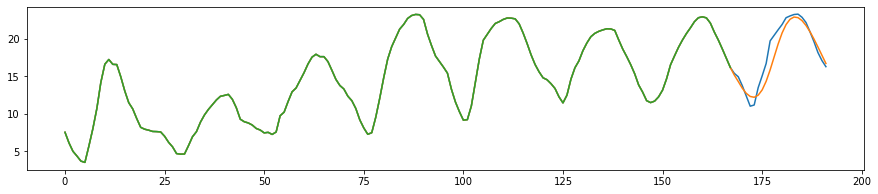

In [44]:
# Sample plots
for x_test, y_test in test_ds.take(1):

    for idx in range(batch_size):
        
        sample_x = x_test[idx, ...].numpy()[:, 0]#[-24*4:]
        sample_y = y_test[idx, ...].numpy()
        sample_forecast = model.predict(x_test[np.newaxis, idx]).squeeze(-1)[0]

        # Inverse transform
        sample_x = (sample_x*train_std[target][0]) + train_mean[target][0]
        sample_y = (sample_y*train_std[target][0]) + train_mean[target][0]
        sample_forecast = (sample_forecast*train_std[target][0]) + train_mean[target][0]
        
        print("RMSE: ", np.sqrt(tf.keras.metrics.mse(sample_y, sample_forecast).numpy()))
        print(" MAE: ", tf.keras.metrics.mae(sample_y, sample_forecast).numpy())
        plt.plot(np.append(sample_x, sample_y))
        plt.plot(np.append(sample_x, sample_forecast))
        plt.plot(sample_x)
        plt.show()

        if idx > 5: break

## Metrics

In [57]:
errs_seq2seq = {'RMSE': [], 'MAE': []}
for x_test, y_test in test_ds:
    
    forecast = model.predict(x_test).squeeze(-1)
    
    errs_seq2seq['RMSE'].append(np.sqrt(tf.keras.metrics.mse(y_test, forecast).numpy()).mean())
    errs_seq2seq['MAE'].append(tf.keras.metrics.mae(y_test, forecast).numpy().mean())

print('In celsius:')
print("Avg. RMSE: ", np.mean(errs_seq2seq['RMSE']))
print(" Avg. MAE: ", np.mean(errs_seq2seq['MAE']))

In celsius:
Avg. RMSE:  0.24712487
 Avg. MAE:  0.20840418


## References

---

[1] https://www.tensorflow.org/tutorials/structured_data/time_series

[2] Chollet, F. (2021). Deep learning with Python (Second Edition). Simon and Schuster.